In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from rasterio import plot
import pandas as pd
import sys
import os
import time
# import somoclu
# #from dbfread import DBF
# import earthpy.plot as ep
import gdal
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVR
from sklearn.neighbors import KNeighborsClassifier

#custom files import

from skimage import *


import skimage.data as data
import skimage.segmentation as seg
import skimage.filters as filters
import skimage.draw as draw
import skimage.color as color
import skimage.io as io


# from quality_assessment import *


data_folder_path = '/home/chris/Desktop/diploma/Diploma-Workspace/Data/'
labels_folder_path = '/home/chris/Desktop/diploma/Diploma-Workspace/Ground_Truth_Data/'
# landsat_dataset = 'Landsat8_dataset/'
# sentinel_dataset = 'Sentinel2_dataset/'

cropped_data ='cropped_data/'

landsat_use_bands = [2, 4, 5, 12]
sentinel_use_bands = [2, 4, 8, 'TCI', 'cloud_mask']
landsat8_name = 'landsat8_band_'
sentinel2_name = 'sentinel2_band_'


crop_name = ['Cotton', 'Corn', 'Peanuts']
mask_suffix = '_mask.tif'

In [2]:
#IMPORT LABELS


#Read as TIF
crop_data_tif = gdal.Open(labels_folder_path + 'CDL.tif')
crop_mask_tif = gdal.Open(labels_folder_path + 'CMASK.tif')
crops_only_tif = gdal.Open(labels_folder_path + 'CDL_CROPS_ONLY.tif')

cotton_tif = gdal.Open(labels_folder_path + crop_name[0] + mask_suffix)
#fallow_2_tif = gdal.Open(labels_folder_path + 'CDL_FALLOW_2.tif')
peanuts_tif = gdal.Open(labels_folder_path + crop_name[2] + mask_suffix)
#other_hay_4_tif = gdal.Open(labels_folder_path + 'CDL_OTHER_HAY_NO_ALFALA_4.tif')
corn_tif = gdal.Open(labels_folder_path + crop_name[1] + mask_suffix)

#Read as Arrays
crop_data = np.array(crop_data_tif.GetRasterBand(1).ReadAsArray())# crop_data_tif.read(1).astype('float64')
crop_mask = np.array(crop_mask_tif.GetRasterBand(1).ReadAsArray()) #crop_mask_tif.read(1).astype('float64')
crops_only = np.array(crops_only_tif.GetRasterBand(1).ReadAsArray()) #crops_only_tif.read(1).astype('float64')

cotton_array = np.array(cotton_tif.GetRasterBand(1).ReadAsArray()) #cotton_1_tif.read(1).astype('float64')
#fallow_2 = np.array(fallow_2_tif.GetRasterBand(1).ReadAsArray()) #fallow_2_tif.read(1).astype('float64')
peanuts_array = np.array(peanuts_tif.GetRasterBand(1).ReadAsArray()) #peanuts_3_tif.read(1).astype('float64')
#other_hay_4 = np.array(other_hay_4_tif.GetRasterBand(1).ReadAsArray()) #other_hay_4_tif.read(1).astype('float64')
corn_array = np.array(corn_tif.GetRasterBand(1).ReadAsArray()) #corn_5_tif.read(1).astype('float64')



#read csv with crops type
labels = pd.read_csv(labels_folder_path + 'CDL_data.tif.vat.csv')
labels = labels.rename(columns=lambda x: x.strip())
existing_labels = pd.read_csv(labels_folder_path + 'cdl_existing_labels.csv')
existing_labels = existing_labels.rename(columns=lambda x: x.strip())
existing_crop_labels = pd.read_csv(labels_folder_path + 'cdl_existing_crop_labels.csv')
existing_crop_labels = existing_labels.rename(columns=lambda x: x.strip())

idx1 = (pd.Index(existing_labels['Value'])).union([0])
idx2 = np.unique(crops_only)

# print((idx1))
# print((idx2))

all_existing_labels = labels[labels['VALUE'].isin(idx1)]
crop_existing_labels = labels[labels['VALUE'].isin(idx2)]

# print(all_existing_labels)
# print(crop_existing_labels)

In [3]:
# print(type(labels))
# print(labels)
# print(type(existing_labels))
# print(existing_labels)
# print(all_existing_labels)
# print(crop_existing_labels)

In [4]:
# ## print(existing_labels.columns)
# test = existing_labels.columns
# print(type(test))
# print(existing_labels.index)
# print((existing_labels.loc[1][2]))
# print(type(existing_labels.iloc[:,1:3]))
# temp = existing_labels.iloc[:,1].values.tolist()

In [5]:
names = existing_labels.iloc[:,1].values.tolist()
print((names))
pixels_count = existing_labels.iloc[:,2].values.tolist()
print(pixels_count)
acreage = existing_labels.iloc[:,3].values.tolist()
print(acreage)

combined_data = [names, pixels_count, acreage]
print(combined_data[2][0])

print(type(existing_labels.values.tolist()))
print(existing_labels.columns[2])
print(existing_labels['Count'])

[' Corn', ' Cotton', ' Sorghum', ' Soybeans', ' Peanuts', ' Winter Wheat', ' Dbl Crop WinWht/Soybeans', ' Rye', ' Oats', ' Millet', ' Alfalfa', ' Other Hay/Non Alfalfa', ' Watermelons', ' Peas', ' Tomatoes', ' Herbs', ' Clover/Wildflowers', ' Sod/Grass Seed', ' Fallow/Idle Cropland', ' Grapes', ' Pecans', ' Open Water', ' Developed/Open Space', ' Developed/Low Intensity', ' Developed/Medium Intensity', ' Developed/High Intensity', ' Barren', ' Deciduous Forest', ' Evergreen Forest', ' Mixed Forest', ' Shrubland', ' Grass/Pasture', ' Woody Wetlands', ' Herbaceous Wetlands', ' Cantaloupes', ' Strawberries', ' Squash', ' Dbl Crop Oats/Corn', ' Dbl Crop WinWht/Sorghum', ' Dbl Crop WinWht/Cotton', ' Dbl Crop Corn/Soybeans']
[17286, 145216, 429, 9023, 89712, 8391, 19, 2620, 1785, 736, 2, 77936, 53, 453, 76, 10, 2, 176, 97161, 13, 101, 5200, 44211, 4810, 2129, 617, 438, 5324, 293623, 1236, 175869, 10909, 156993, 1870, 398, 6, 24, 52, 17, 992, 72]
[3844.3, 32295.3, 95.4, 2006.7, 19951.5, 1866.

In [6]:
#IMPORT SATELLITE DATA
def read_data_from_1_date(dataset, use_bands, satellite_name):
    data =[]
    data_list = []
    files = []

    number_of_files = len(os.listdir(dataset))
    for i in use_bands:
        temp = rasterio.open(dataset + cropped_data + satellite_name + str(i) + '.tif')
        data.append(temp)
        data_list.append(temp.read(1).astype('float64'))

            
    number_of_bands = len(data_list)
    print(number_of_bands)
    data_array = np.array(data_list)
    return data_array

In [7]:
#NDVI
def calculate_NDVI(red, nir):

    ndvi = np.where((nir+red)==0., 0, (nir-red)/(nir+red))
    ndvi = ndvi[np.newaxis,:,:]
    return ndvi

In [8]:
#EVI
def calculate_EVI(blue, red, nir):
    evi = np.where((nir + 6*red - 7.5*blue + 1)==0., 0, 2.5*(nir-red)/(nir + 6*red - 7.5*blue + 1))
    evi = evi[np.newaxis,:,:]
    return evi

In [9]:
def calculate_means_of_classes_in_1_band(data, labels):
    dif_labels = np.unique(labels)
    means = []
    no_data = -9999
    for label in dif_labels:
        labeled_pixels = data[labels==label]
        labeled_pixels_without_no_value = labeled_pixels[labeled_pixels!=no_data]

        denominator = len(labeled_pixels_without_no_value)
        if denominator == 0: denominator = 1
        means.append(np.sum(labeled_pixels_without_no_value)/denominator)

    return means

In [10]:
def fill_missing_values_in_1_band(data,labels,means):
    
    dif_labels = np.unique(labels)
    no_data = -9999
    no_data_values = data==no_data
    for idx,label in enumerate(dif_labels):
        label_values = labels==label
        values_to_fill = np.logical_and(no_data_values, label_values)
        data = np.where(values_to_fill, means[idx], data)
    return data

In [11]:
def landsat_mask(data,quality_band):
    # 2720 - CLEAR
    # 2752 - CLOUD CONFIDENCE MEDIUM
    # 2800 - CLOUD
    # 2976 - CLOUD SHADOW HIGH
    # 3008 - CIRRUS CONFIDENCE LOW
    
    #Valid Data Values 2720, 2724, 2728, 2732
    data_values = np.array([2720, 2724, 2728, 2732])
    
    mask = np.where(np.isin(quality_band,data_values), 1, -1)  
    
    num_of_bands = np.size(data, axis=0)
    for i in range(num_of_bands):
        data[i] = np.multiply(data[i], mask)
    
    return np.where(data<0, -9999, data)

In [12]:
def sentinel_mask(data, mask):
    #Five 0 => clear land pixel
    #1 => clear water pixel
    #2 => cloud shadow
    #3 => snow
    #4 => cloud
    #255 => no observation
    mask = np.where(mask<2, 1, -1)
#     print("MASK")
#     plt.figure(figsize=(20,20))  
#     plot.show(mask)
    
#     plt.figure(figsize=(20,20))  
#     plot.show(data)
    
    num_of_bands = np.size(data, axis=0)
    for i in range(num_of_bands):
        data[i] = np.multiply(data[i], mask)
    
  
    return np.where(data<0, -9999, data)

In [13]:
#Finding the paths of the datasets' folders
datasets_list = os.listdir(data_folder_path)
for dataset in datasets_list:
    
    sentinel_dataset = data_folder_path + list(filter(lambda x: x.startswith('Sentinel'), datasets_list))[0] + '/'
    landsat_dataset = data_folder_path + list(filter(lambda x: x.startswith('Landsat'), datasets_list))[0] + '/'
sentinel_dataset_list = os.listdir(sentinel_dataset)
landsat_dataset_list = os.listdir(landsat_dataset)

sentinel_dataset_list = list(map(( lambda x: x + '/'), sentinel_dataset_list))
landsat_dataset_list = list(map(( lambda x: x + '/'), landsat_dataset_list))

sentinel_dataset_list.sort()
landsat_dataset_list.sort()

print(sentinel_dataset_list)
print(landsat_dataset_list)
print(sentinel_dataset)
print(landsat_dataset)

['2018_02_24_Sentinel2/', '2018_04_05_Sentinel2/', '2018_04_20_Sentinel2/', '2018_06_04_Sentinel2/', '2018_06_29_Sentinel2/', '2018_08_23_Sentinel2/', '2018_09_12_Sentinel2/', '2018_11_16_Sentinel2/']
['2018_01_25_Landsat8/', '2018_03_14_Landsat8/', '2018_05_01_Landsat8/', '2018_08_05_Landsat8/', '2018_09_22_Landsat8/', '2018_10_24_Landsat8/']
/home/chris/Desktop/diploma/Diploma-Workspace/Data/Sentinel2 _dataset/
/home/chris/Desktop/diploma/Diploma-Workspace/Data/Landsat8_dataset/


In [14]:
#Read satellite data and apply mask
landsat_raw_data = []
landsat_masked_data = []
landsat_filled_data =[]
landsat_ndvi = []
landsat_evi = []

sentinel_raw_data = []
sentinel_masked_data = []
sentinel_filled_data =[]
sentinel_ndvi = []
sentinel_evi = []

#Read Raw Data and Apply Masks
for date in landsat_dataset_list:
    temp = read_data_from_1_date(landsat_dataset + date, landsat_use_bands, landsat8_name)
    print(temp.shape)
    landsat_raw_data.append(temp)
    landsat_masked_data.append(landsat_mask(temp[:-1,:,:], temp[-1]))

for date in sentinel_dataset_list:
    temp = read_data_from_1_date(sentinel_dataset + date, sentinel_use_bands, sentinel2_name)
    sentinel_raw_data.append(temp)
    sentinel_masked_data.append(sentinel_mask(temp[:-1,:,:],temp[-1]))

#Fill Masked Values
for date in landsat_masked_data:
    temp = []
    for band in date:
        means = calculate_means_of_classes_in_1_band(band, crops_only)
        temp.append(fill_missing_values_in_1_band(band, crops_only, means))
    landsat_filled_data.append(np.array(temp))
    
for date in sentinel_masked_data:
    temp = []
    for band in date:
        means = calculate_means_of_classes_in_1_band(band, crops_only)
        temp.append(fill_missing_values_in_1_band(band, crops_only, means))
    sentinel_filled_data.append(np.array(temp))
    
    
#Calculate Indeces NDVI, EVI
for date in landsat_filled_data:
    landsat_ndvi.append(calculate_NDVI(date[1], date[2]))
    landsat_evi.append(calculate_EVI(date[0], date[1], date[2]))

for date in sentinel_filled_data:
    sentinel_ndvi.append(calculate_NDVI(date[1], date[2]))
    sentinel_evi.append(calculate_EVI(date[0], date[1], date[2]))


4
(4, 678, 1706)
4
(4, 678, 1706)
4
(4, 678, 1706)
4
(4, 678, 1706)
4
(4, 678, 1706)
4
(4, 678, 1706)
5
5
5
5
5
5
5
5


/home/chris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/chris/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


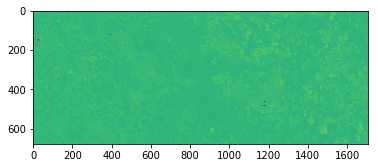

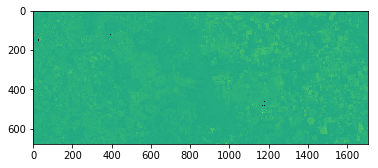

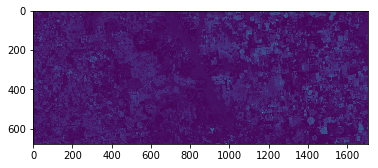

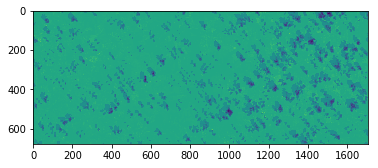

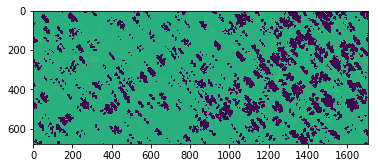

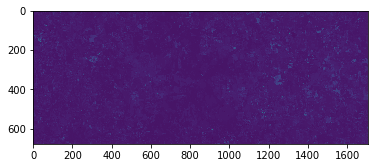

In [15]:
plot.show(landsat_raw_data[0][0])
plot.show(landsat_masked_data[0][0])
plot.show(landsat_filled_data[0][0])
plot.show(sentinel_raw_data[6][0])
plot.show(sentinel_masked_data[6][0])
plot.show(sentinel_filled_data[6][0])

In [16]:
landsat_number_of_bands_ndvi = len(landsat_ndvi)
landsat_number_of_bands_evi = len(landsat_evi)
sentinel_number_of_bands_ndvi = len(sentinel_ndvi)
sentinel_number_of_bands_evi = len(sentinel_evi)

print(landsat_ndvi[0].shape)
print(sentinel_ndvi[0].shape)
print(landsat_number_of_bands_ndvi)
print(landsat_number_of_bands_evi)
print(sentinel_number_of_bands_ndvi)
print(sentinel_number_of_bands_evi)


ndvi = landsat_ndvi + sentinel_ndvi
evi = landsat_evi + sentinel_evi

(1, 678, 1706)
(1, 678, 1706)
6
6
8
8


In [17]:
all_data_dates = landsat_dataset_list + sentinel_dataset_list
print(all_data_dates)
all_data_dates, ndvi = zip(*sorted(zip(all_data_dates, ndvi)))
all_data_dates, evi = zip(*sorted(zip(all_data_dates, evi)))

['2018_01_25_Landsat8/', '2018_03_14_Landsat8/', '2018_05_01_Landsat8/', '2018_08_05_Landsat8/', '2018_09_22_Landsat8/', '2018_10_24_Landsat8/', '2018_02_24_Sentinel2/', '2018_04_05_Sentinel2/', '2018_04_20_Sentinel2/', '2018_06_04_Sentinel2/', '2018_06_29_Sentinel2/', '2018_08_23_Sentinel2/', '2018_09_12_Sentinel2/', '2018_11_16_Sentinel2/']


In [18]:
data_array_ndvi = np.squeeze(np.array(ndvi))
data_array_evi = np.squeeze(np.array(evi))
data_array_combined = (np.append(data_array_ndvi, data_array_evi, axis=0))

print(len(data_array_combined))
number_of_bands_combined = len(data_array_combined)
print(data_array_combined.shape)

data_array_combined_flatten = np.transpose(data_array_combined.reshape((number_of_bands_combined,-1)))
crops_only_flatten = crops_only.reshape((-1))
print(data_array_combined_flatten.shape)
print(crops_only_flatten.shape)

28
(28, 678, 1706)
(1156668, 28)
(1156668,)


In [19]:
def array_to_raster(array, old_raster_used_for_projection, save_path):

    width = old_raster_used_for_projection.RasterYSize
    height = old_raster_used_for_projection.RasterXSize
    gt = old_raster_used_for_projection.GetGeoTransform()
    wkt_projection = old_raster_used_for_projection.GetProjectionRef()

    if len(array.shape)==2:
        array = np.expand_dims(array, axis=0)

    no_bands =  array.shape[0]
    
    driver = gdal.GetDriverByName('GTiff')
    print(driver)
    DataSet = driver.Create(save_path, height, width, no_bands, gdal.GDT_Float64)
    DataSet.SetGeoTransform(gt)
    DataSet.SetProjection(wkt_projection)

    for i in range(no_bands):
        DataSet.GetRasterBand(i+1).WriteArray(array[i])
    DataSet = None
    
    return save_path

14


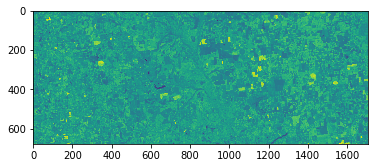

<osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x7f60003ba390> >
<osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x7f60003ba390> >


'/home/chris/Desktop/diploma/Diploma-Workspace/Data/EVI_raster.tif'

In [20]:
print(data_array_ndvi.shape[0])
plot.show(data_array_ndvi[0])

array_to_raster(data_array_ndvi,crops_only_tif,data_folder_path + "NDVI_raster.tif")
array_to_raster(data_array_evi,crops_only_tif,data_folder_path + "EVI_raster.tif")

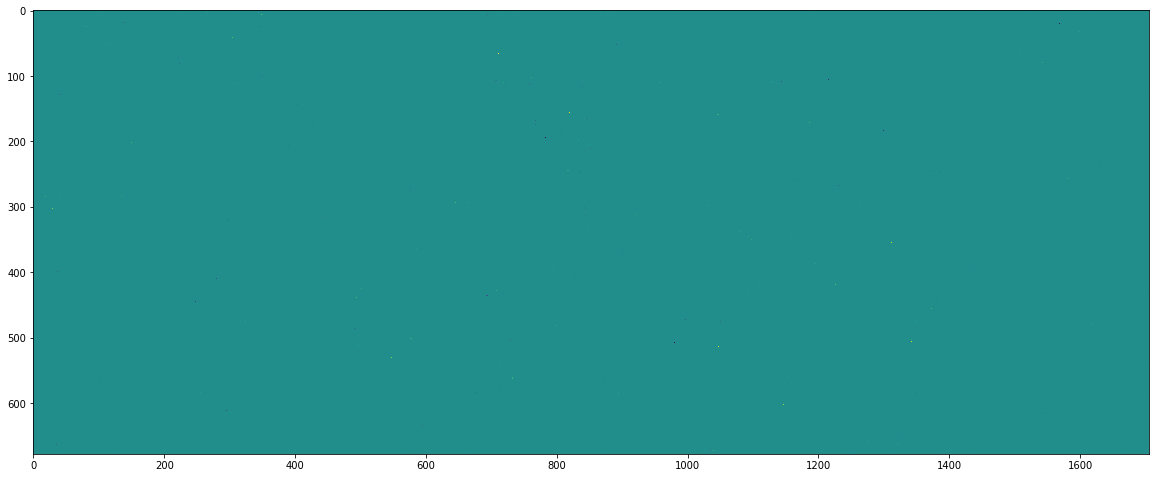

In [27]:
plt.figure(figsize=(20,20)) 
plot.show(data_array_evi[2])

In [23]:
x, y = data_array_combined_flatten.shape
print(x,y)
X_train, X_test, y_train, y_test = train_test_split(data_array_combined_flatten, crops_only_flatten, test_size=0.20, random_state=42)
print(X_train.shape)
print(y_train.shape)

1156668 28
(925334, 28)
(925334,)


In [24]:
clf = RandomForestClassifier(random_state=0)
start_train = time.time()
clf.fit(X_train, y_train)
end_train = time.time()
print(end_train - start_train)

start_test = time.time()
result = clf.score(X_test,y_test)
end_test = time.time()
print(end_test - start_test)

print(result)



1175.9158205986023
9.120448589324951
0.931078008420725


In [42]:
clf = RandomForestClassifier(random_state=0)
start_train = time.time()
clf.fit(X_train, y_train)
end_train = time.time()
print(end_train - start_train)

start_test = time.time()
result = clf.score(X_test,y_test)
end_test = time.time()
print(end_test - start_test)

print(result)



1004.0634915828705
29.17009139060974
0.9058590609248964


In [37]:
print(clf.classes_)
print(clf.n_classes_)
print(clf.n_outputs_)
print(clf.n_features_)
print(clf.feature_importances_)
print((np.unique(crops_only)))
print()

[  0.   1.   2.   4.   5.  10.  24.  26.  27.  28.  29.  36.  37.  48.
  53.  54.  57.  58.  59.  61.  69.  74. 176. 209. 221. 222. 226. 236.
 238. 241.]
30
1
12
[0.09862445 0.06759351 0.13537938 0.08274494 0.06301665 0.0754009
 0.07356232 0.06165048 0.14775653 0.07282304 0.05190109 0.06954671]
[  0.   1.   2.   4.   5.  10.  24.  26.  27.  28.  29.  36.  37.  48.
  53.  54.  57.  58.  59.  61.  69.  74. 176. 209. 221. 222. 226. 236.
 238. 241.]



In [39]:
temp = [estimator.tree_.max_depth for estimator in clf.estimators_]
print(len(temp))
print(np.mean(np.array(temp)))
print(np.amax(np.array(temp)))
print(np.amin(np.array(temp)))

100
42.74
51
38


In [17]:
score = []

In [26]:
neigh_num = 30
neigh = KNeighborsClassifier(n_neighbors=neigh_num)

start_train = time.time()
neigh.fit(X_train, y_train)
end_train = time.time()

print(end_train - start_train)

start_test = time.time()
result = neigh.score(X_test,y_test)
end_test = time.time()

print(end_test - start_test)

score.append([neigh_num, result])

print(result)
print(score)

10.901137828826904
298.83959555625916
0.7754156328079747


In [28]:
#na allaksw tis parametrous gia na mhn vgainei negative
linear_svm = LinearSVR()

start_train = time.time()
linear_svm.fit(X_train, y_train)
end_train = time.time()
print(end_train - start_train)

start_test = time.time()
result = linear_svm.score(X_test,y_test)
end_test = time.time()
print(result)
print(end_test - start_test)


851.3136830329895
-0.14409275305420843
0.01989006996154785


/home/chris/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
